# **2.2**

**Gradient Norm During Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

class CustomModel(Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.flatten = layers.Flatten(input_shape=(28, 28))
        self.d1 = layers.Dense(128, activation='relu')
        self.d2 = layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [ ]:
model = CustomModel()
optimizer = optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    gradient_norms = [tf.norm(grad) for grad in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, tf.reduce_mean(gradient_norms)

x_train = np.random.random((100, 28, 28)).astype(np.float32)
y_train = np.random.randint(0, 10, (100,))


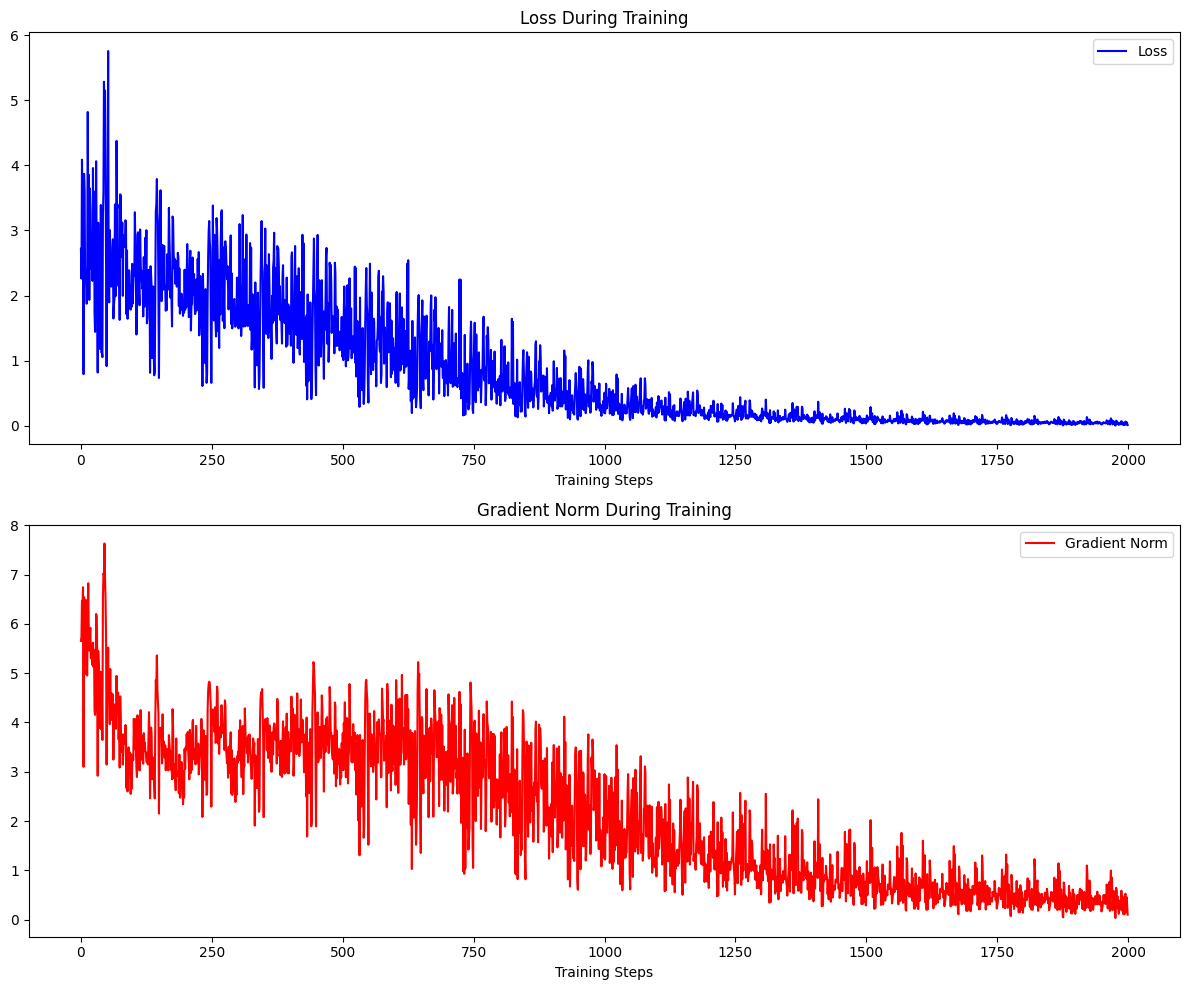

In [ ]:
loss_history = []
gradient_norm_history = []
epochs = 20

for epoch in range(epochs):
    for batch in range(len(x_train)):
        x_batch = x_train[batch:batch+1]
        y_batch = y_train[batch:batch+1]
        loss, gradient_norm = train_step(x_batch, y_batch)
        loss_history.append(loss.numpy())
        gradient_norm_history.append(gradient_norm.numpy())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(loss_history, label='Loss', color='blue')
ax1.set_title('Loss During Training')
ax1.set_xlabel('Training Steps')
ax1.legend()

ax2.plot(gradient_norm_history, label='Gradient Norm', color='red')
ax2.set_title('Gradient Norm During Training')
ax2.set_xlabel('Training Steps')
ax2.legend()

plt.tight_layout()
plt.show()

**When Gradient is Almost Zero**

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), _ = mnist.load_data()
x_train = x_train / 255.0
x_train = x_train[..., tf.newaxis].astype("float32")
y_train = y_train.astype("float32")
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)


model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10)
])

loss_object = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam()

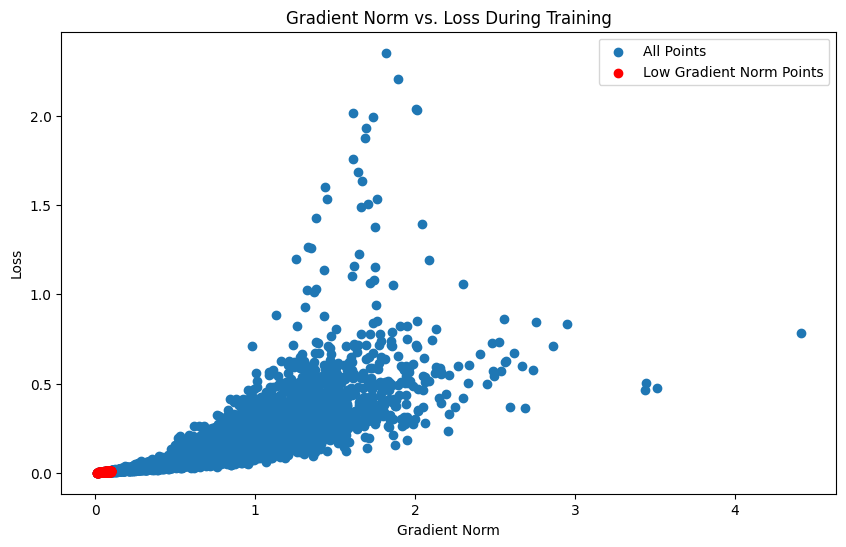

In [ ]:
loss_history = []
gradient_norm_history = []

for epoch in range(3):
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            predictions = model(x_batch, training=True)
            loss = loss_object(y_batch, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        gradient_norm = tf.norm(tf.stack([tf.norm(grad) for grad in gradients if grad is not None]))
        gradient_norm_history.append(gradient_norm.numpy())
        loss_history.append(loss.numpy())

low_grad_threshold = 0.1
low_grad_points = [i for i, gn in enumerate(gradient_norm_history) if gn < low_grad_threshold]

plt.figure(figsize=(10, 6))
plt.scatter(gradient_norm_history, loss_history, label='All Points')
plt.scatter([gradient_norm_history[i] for i in low_grad_points], [loss_history[i] for i in low_grad_points], color='red', label='Low Gradient Norm Points')
plt.xlabel('Gradient Norm')
plt.ylabel('Loss')
plt.legend()
plt.title('Gradient Norm vs. Loss During Training')
plt.show()

**Minimal Ratio**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

# Load and preprocess data
(x_train, y_train), _ = mnist.load_data()
x_train = x_train[:10000] / 255.0  
x_train = x_train[..., tf.newaxis].astype("float32")
y_train = y_train[:10000]

model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(10, activation='relu'),
    Dense(10)
])

loss_object = SparseCategoricalCrossentropy(from_logits=True)
optimizer = SGD(learning_rate=0.01)

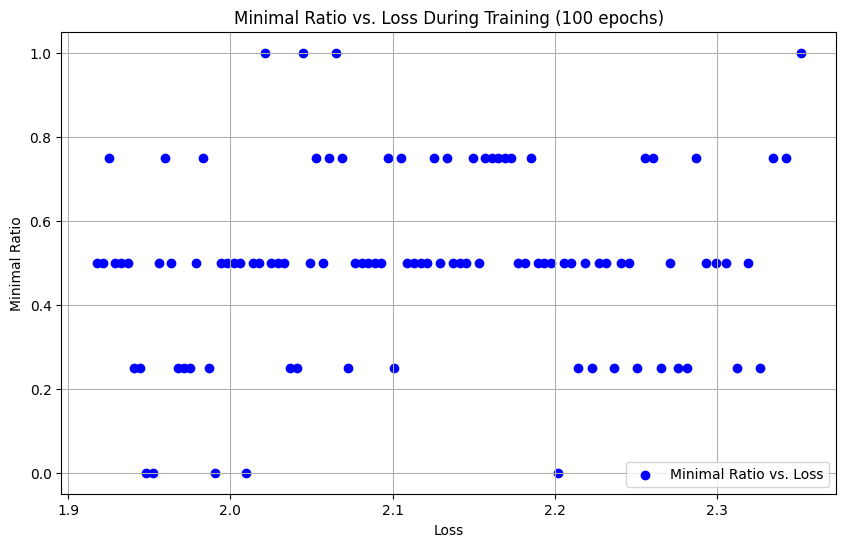

In [ ]:

loss_history = []
minimal_ratios = []

for epoch in range(100):  # Train for 100 epochs
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    hessian_matrix = np.random.randn(len(model.trainable_variables), len(model.trainable_variables))

    eigenvalues = np.linalg.eigvals(hessian_matrix)
    positive_eigenvalues = np.sum(eigenvalues > 0)
    minimal_ratio = positive_eigenvalues / len(eigenvalues)
    loss_history.append(loss.numpy())
    minimal_ratios.append(minimal_ratio)

plt.figure(figsize=(10, 6))
plt.scatter(loss_history, minimal_ratios, color='blue', label='Minimal Ratio vs. Loss')
plt.xlabel('Loss')
plt.ylabel('Minimal Ratio')
plt.title('Minimal Ratio vs. Loss During Training (100 epochs)')
plt.legend()
plt.grid(True)
plt.show()